# Batch size timing
* CPU time scales linearly with batch size: $\mathcal{O}(n)$
* GPU time scales constant with batch size: $\mathcal{O}(1)$ until batch size 172, then it becomes linear.
* The slight increase in time between batch size 24 and 96 may be due to benchmarking. Re-benchmarking for this batch size might bring it down to 2.7
* All FP16 is slower

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
matplotlib.rcParams.update({'font.size': 13})

In [2]:
data = pd.read_csv('../misc/timing.csv')
data.head()

,Batch Size,CPU Time (ms),GPU Time (ms)
0,1,2.48,2.67
1,2,2.81,2.67
2,3,3.33,2.66
3,4,3.73,2.74
4,5,4.20,2.66


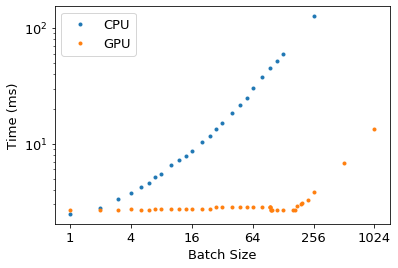

In [3]:
plt.loglog(data.iloc[:,0], data.iloc[:,1:], '.', basex=2)
plt.ylabel('Time (ms)')
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,256,1024])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(['CPU', 'GPU'])
plt.show()

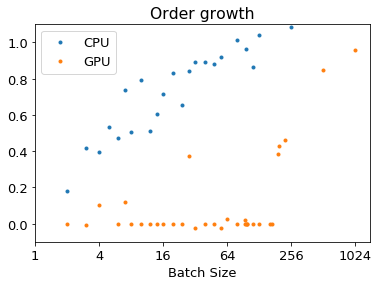

In [4]:
logdata = np.log(data)
cpulogdata = logdata.dropna()
cpudiff = cpulogdata.iloc[:,1].diff() / cpulogdata.iloc[:,0].diff()
gpudiff = logdata.iloc[:,2].diff() / logdata.iloc[:,0].diff()

plt.semilogx(np.exp(cpulogdata.iloc[:,0]), cpudiff, '.', basex=2)
plt.semilogx(np.exp(logdata.iloc[:,0]), gpudiff, '.', basex=2)
plt.title('Order growth')
plt.ylim([-.1,1.1])
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,256,1024])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(['CPU', 'GPU'])
plt.show()

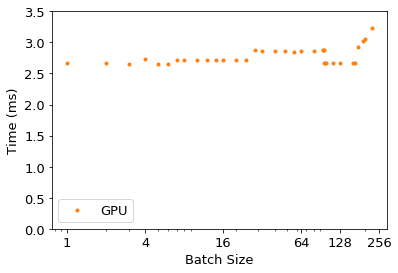

In [5]:
plt.semilogx(data.iloc[:-3,0], data.iloc[:-3,2], '.', color=plt.cm.tab10(1))
plt.legend(['GPU'], loc='lower left')
plt.ylabel('Time (ms)')
plt.ylim([0, 3.5])
plt.xlabel('Batch Size')
plt.xticks([1,4,16,64,128,256])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# BatchNetTree timing

In [ ]:
import numpy as np
import torch
from time import time
from network import UTTTNet
from net_player import NetPlayer
from play import play

best_net = '500_5000bs2048lr0.1d0.001e4'
device = 'cpu'
print(f'Using network {best_net}')
m = UTTTNet()
m.load_state_dict(torch.load(f'../models/{best_net}.pt',
                             map_location=device))
m = m.to(device).eval()

from engine import *
from tree import *
from net_player import *

In [ ]:
game2 = [(4, 4), (4, 0), (0, 0), (0, 8), (8, 8), (8, 1), (1, 1), (1, 3), (3, 3), (3, 7), (7, 7), (7, 3), (3, 6), (6, 7), (7, 6), (6, 1), (1, 0), (0, 3), (3, 0), (0, 5), (5, 5), (5, 7), (7, 8), (8, 2), (2, 2), (2, 5), (5, 8), (8, 0), (0, 4), (4, 6), (6, 6), (6, 4), (4, 3), (0, 2), (2, 1), (1, 2), (2, 0), (4, 1), (1, 5), (5, 1), (1, 4), (4, 2)]
b = BigBoard()
for move in game2[:-6]: 
    b.move(*move)

b.draw()

In [ ]:
time1 = time()
r = Root()
t = NetTree(b, r, model=m, noise=False, device=device)
for _ in range(5000):
    t.explore()
    if r.terminal[0]:
        break
print(time()-time1)
print(f'Took {t.N.sum() - len(t.N)} nodes')
print(t.Q_over_N())

In [ ]:
time1 = time()
r = Root()
t = BatchNetTree(b, r, model=m, noise=False, device=device)
nodes_left = 5000
while nodes_left:
    nodes_searched = t.explore_batch(nodes_left=nodes_left)
    nodes_left -= nodes_searched
    # print(f'Nodes searched: {nodes_searched}, Nodes left: {nodes_left}')
    if r.terminal[0]:
        break
print(time()-time1)
print(f'Took {t.N.sum() - len(t.N)} nodes')
print(t.Q_over_N())

| Method              | Time (ms) per eval | Nodes to solve        |
|:--------------------|:-------------------|:----------------------|
| CPU                 | 2.45               | 788                   |
| CPU Batching        | 2.98               | 788                   |
| GPU                 | 1.10               | 843                   |
| GPU Batching        | 0.78               | 843                   |

#### Game 2 -8 moves analysis
Cuda time: 51.80193281173706 for 50000 nodes.

Estimated value is very close to previous single batch analysis. Value of best move off by 5%.

`[-0.1307422  -1.         -0.69468112 -1.         -0.702226   -1.  -0.69159733]`

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
matplotlib.rcParams.update({'font.size': 13})
data = pd.read_csv('../misc/Game2-8.csv')
data.head()

,Nodes Searched,Nodes Left
0,3,49997
1,12,49985
2,17,49968
3,36,49932
4,83,49849


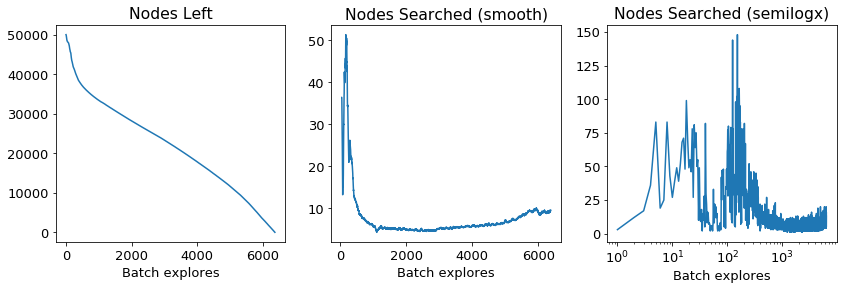

In [42]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(data['Nodes Left'])
plt.xlabel('Batch explores')
plt.title('Nodes Left')
plt.subplot(132)
plt.plot(data['Nodes Searched'].rolling(50).mean())
plt.xlabel('Batch explores')
plt.title('Nodes Searched (smooth)')
plt.subplot(133)
plt.semilogx(np.arange(len(data['Nodes Searched']))+1, data['Nodes Searched'])
plt.xlabel('Batch explores')
plt.title('Nodes Searched (semilogx)')
plt.show()

For this specific example, the batch size stayed below ~150.

# CPU versus GPU_Batch

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
matplotlib.rcParams.update({'font.size': 13})

#### Selfplay @ 1k nodes

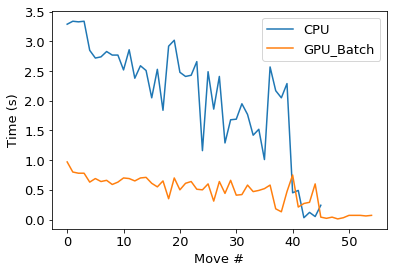

CPU/GPU time: 4.454199182460052


In [27]:
data = pd.read_csv('../misc/CPU_GPU_selfplay.csv')
plt.plot(data['CPU'])
plt.plot(data['GPU_Batch'])
plt.xlabel('Move #')
plt.ylabel('Time (s)')
plt.legend(['CPU', 'GPU_Batch'])
plt.show()
print('CPU/GPU time:', data['CPU'].mean() / data['GPU_Batch'].mean())

#### Versus @ 100 nodes

In [92]:
data = np.loadtxt('../misc/cpu_gpu.txt', dtype=str)
cpu = []
gpu = []
tot = [cpu, gpu]
move_num = 0
starter = 0
mover = 0

for x in data[1:]:
    if x != 'Newgame':
        while len(tot[mover]) <= move_num:
            tot[mover].append([])
        tot[mover][move_num].append(float(x))
        move_num += 1
        mover = 1 - mover
    else:
        move_num = 0
        starter = 1 - starter
        mover = starter
        
gpu[1].pop(0)  # First gpu iter is slow due to init

cpu_mean = np.array([np.mean(scores) for scores in cpu])
gpu_mean = np.array([np.mean(scores) for scores in gpu])
cpu_std = np.array([np.std(scores) for scores in cpu])
gpu_std = np.array([np.std(scores) for scores in gpu])

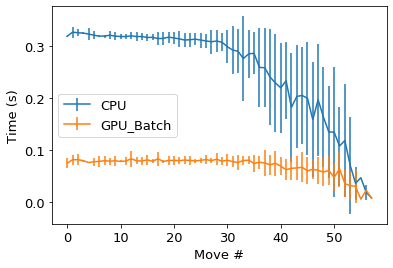

In [103]:
plt.errorbar(x=np.arange(len(cpu_mean)),y=cpu_mean, yerr=cpu_std)
plt.errorbar(x=np.arange(len(gpu_mean)),y=gpu_mean, yerr=gpu_std)
plt.xlabel('Move #')
plt.ylabel('Time (s)')
plt.legend(['CPU', 'GPU_Batch'], loc='center left')
plt.show()

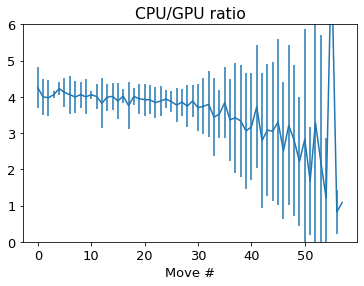

In [100]:
# Covariance between cpu and gpu is zero because they are independent variables
plt.errorbar(x=np.arange(len(cpu_mean)),
             y=cpu_mean/gpu_mean,
             yerr=np.sqrt(cpu_std**2/gpu_mean**2 + gpu_std**2 * cpu_mean**2/gpu_mean**4))
plt.ylim([0, 6])
plt.xlabel('Move #')
plt.title('CPU/GPU ratio')
plt.show()

Ratio starts out

In [109]:
np.mean([s for scores in cpu for s in scores]) / np.mean([s for scores in gpu for s in scores])

3.7830059927665793

#### Versus @ 378 nodes
Give GPU_Batch additional nodes to compensate for faster times

In [112]:
data = np.loadtxt('../misc/cpu_gpu_378.txt', dtype=str)
cpu = []
gpu = []
tot = [cpu, gpu]
move_num = 0
starter = 0
mover = 0

for x in data[1:]:
    if x != 'Newgame':
        while len(tot[mover]) <= move_num:
            tot[mover].append([])
        tot[mover][move_num].append(float(x))
        move_num += 1
        mover = 1 - mover
    else:
        move_num = 0
        starter = 1 - starter
        mover = starter
        
gpu[1].pop(0)  # First gpu iter is slow due to init

cpu_mean = np.array([np.mean(scores) for scores in cpu])
gpu_mean = np.array([np.mean(scores) for scores in gpu])
cpu_std = np.array([np.std(scores) for scores in cpu])
gpu_std = np.array([np.std(scores) for scores in gpu])

C:\Users\Felix2\Miniconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Felix2\Miniconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Felix2\Miniconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Felix2\Miniconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Felix2\Miniconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [120]:
print(len(cpu_mean), len(gpu_mean))
gpu_mean = np.append(gpu_mean, np.nan)
gpu_std = np.append(gpu_std, np.nan)

66 65


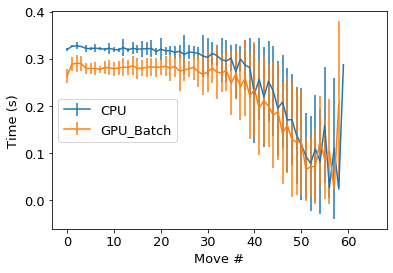

In [121]:
plt.errorbar(x=np.arange(len(cpu_mean)),y=cpu_mean, yerr=cpu_std)
plt.errorbar(x=np.arange(len(gpu_mean)),y=gpu_mean, yerr=gpu_std)
plt.xlabel('Move #')
plt.ylabel('Time (s)')
plt.legend(['CPU', 'GPU_Batch'], loc='center left')
plt.show()

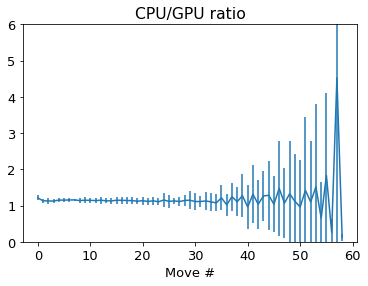

In [122]:
# Covariance between cpu and gpu is zero because they are independent variables
plt.errorbar(x=np.arange(len(cpu_mean)),
             y=cpu_mean/gpu_mean,
             yerr=np.sqrt(cpu_std**2/gpu_mean**2 + gpu_std**2 * cpu_mean**2/gpu_mean**4))
plt.ylim([0, 6])
plt.xlabel('Move #')
plt.title('CPU/GPU ratio')
plt.show()

In [123]:
np.mean([s for scores in cpu for s in scores]) / np.mean([s for scores in gpu for s in scores])

1.1425952256154175

In [126]:
3.78 * 1.14
# I can get away with using an even higher ratio. >4x nodes.

4.3092

# Torchscript timing
For a batch size of 1

In [1]:
import os
os.chdir('../src/')
import matplotlib.pyplot as plt
import numpy as np
import torch
from time import time
from dataset import board_to_planes
from engine import BigBoard
from network import UTTTNet
from selfplay import best_net

In [2]:
moves = [(7, 2), (2, 6), (6, 2), (2, 4), (4, 2), (2, 7), (7, 0), (0, 0), (0, 1), (1, 1), (1, 5), (5, 7), (7, 8), (8, 8), (8, 5), (5, 1), (1, 8), (8, 4), (4, 4), (4, 8), (8, 7), (7, 7), (7, 1), (1, 7), (3, 4), (4, 1), (1, 2), (2, 5), (5, 2), (2, 1), (5, 0), (0, 3), (3, 6), (6, 5), (5, 6)]
b = BigBoard()
for move in moves:
    b.move(*move)
b.draw()

     O │ X │   ┃   │ O │ X ┃   │ O │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │   │   ┃   │   │ X ┃   │ O │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │ O │ X ┃ O │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │   ┃   │ O │ X ┃ X │ O │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │ X │   ┃   │ X │   ┃   │   │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     X │   │   ┃   │   │ O ┃ X │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │ X ┃ X │ X │ X ┃   │   │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │ O ┃   │   │   ┃   │ O │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │ O │ X ┃   │ X │ O         
Mover: O, sector: (6,)
       │ X │ O 
    ───┼───┼───
       │   │   
    ───┼───┼───
       │ X │       


In [ ]:
# torch.backends.cudnn.benchmark = True
device = 'cpu'
trace = True

In [ ]:
print(f'Using network {best_net}')
m = UTTTNet()
m.load_state_dict(torch.load(f'../models/{best_net}.pt',
                             map_location=device))
m = m.to(device).eval()
with torch.no_grad():
    _ = m(board_to_planes(b).to(device))

if trace:
    m = torch.jit.trace(m, board_to_planes(b).to(device))

t = time()
v_total = 0
with torch.no_grad():
    for _ in range(1000):
        p, v = m(board_to_planes(b).to(device))
        v_total += v.item()
t = time() - t
print(f'Time (ms): {t}')
print(f'Value (mu): {v_total}')

#### Model eval results:
| Method              | Time (ms) per eval | w/o `board_to_planes` |
|:--------------------|:-------------------|:----------------------|
| CPU                 | 2.82               | 2.44                  |
| CPU Torchscript     | 2.14               | 1.72                  |
| GPU                 | 3.37               | 2.90                  |
| GPU w/ benchmarking | 3.13               | 2.67                  |
| GPU Torchscript     | 2.43               | 1.95                  |

Notes:
* Torchscript is 30% faster for model eval.
* Once I benchmarked cudnn, it stayed at the faster speed even when I turned it back off.

#### Optimizing `boards_to_planes`
| Method              | Time (ms) per eval |
|:--------------------|:-------------------|
| CPU                 | 0.39               |
| CPU Torchscript     | 0.33               |
| GPU                 | 0.41               |


Notes:
* 0.02 ms to move planes from cpu to cuda
* CPU torchscript is 15% faster but perhaps not worth the trouble of wrapping the function